<a href="https://colab.research.google.com/github/emnordi/ce888/blob/master/Project2/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import os
import io
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

os.environ['KAGGLE_USERNAME'] = "emilnordin" # username from the json file

os.environ['KAGGLE_KEY'] = "fd1ae7405c909d36a1ecffea5cd2749a" # key from the json file

DOWNLOADING AND IMPORTING DATASETS

In [4]:
!kaggle datasets download -d uciml/mushroom-classification

  0% 0.00/34.2k [00:00<?, ?B/s]
100% 34.2k/34.2k [00:00<00:00, 13.1MB/s]


In [5]:
!kaggle datasets download -d emoneyanalytics/unbalancedrisk

  0% 0.00/115k [00:00<?, ?B/s]
100% 115k/115k [00:00<00:00, 33.9MB/s]


In [6]:
!kaggle datasets download -d subediaarjun/unbalanced-fraud-detection-dataset

  0% 0.00/2.57M [00:00<?, ?B/s]
100% 2.57M/2.57M [00:00<00:00, 85.3MB/s]


In [7]:
#This dataset happened to be in excel format requiring some extra steps
!unzip unbalanced-fraud-detection-dataset.zip

Archive:  unbalanced-fraud-detection-dataset.zip
  inflating: Fraud Detection Sample data.xlsx  


In [0]:
data_mush = pd.read_csv('mushroom-classification.zip', compression='zip', header=0, sep=',', quotechar='"', encoding = "utf-8")

In [0]:
#Downsample to get 65% imbalance
mush_p_ind = data_mush[data_mush['class'] == 'p'].index
to_del = mush_p_ind[0:int(len(mush_p_ind)*0.43)]
data_mush_imbalanced = data_mush.drop(index=to_del)

#Convert string data to ints
data_mush_imbalanced_ = pd.get_dummies(data_mush_imbalanced)
data_mush_imbalanced_ = data_mush_imbalanced_.drop('class_e', axis=1)

In [0]:
data_risk = pd.read_csv('unbalancedrisk.zip', compression='zip', header=0, sep=',', quotechar='"', encoding = "utf-8")

In [0]:
data_fraud = pd.read_excel("Fraud Detection Sample data.xlsx", sheet_name = 'credit_card_fraud_sample', header = 0)

PRINTING DATASETS

In [12]:
print(data_risk)

        id  f1        f2  f3   f4  ...   f31         f32    f33      f34  obj1
0        1   1   17.2131   1  1.0  ...  13.0   32.766370    NaN      NaN     0
1        2  35    0.1747   1  1.0  ...  23.0  210.567669    NaN      NaN     0
2        3   1   35.3943   1  NaN  ...  16.0    0.000111    NaN      NaN     1
3        4   1    4.4873   1  1.0  ...   7.0    9.380889    NaN      NaN     0
4        5   1       NaN   1  NaN  ...  20.0   28.089135    NaN      NaN     0
...    ...  ..       ...  ..  ...  ...   ...         ...    ...      ...   ...
4523  4524  29    5.7576   1  1.0  ...  32.0  236.170700    NaN  63.0541     0
4524  4525   2  107.7430   1  1.0  ...  27.0    2.799800    NaN      NaN     1
4525  4526   1    1.9364   1  1.0  ...   NaN  205.806400    NaN  15.9357     1
4526  4527   1    7.6795   1  3.0  ...  10.0    1.658700  533.0      NaN     0
4527  4528   1   80.0871   1  1.0  ...   NaN    2.980200    NaN      NaN     1

[4528 rows x 36 columns]


In [13]:
print(data_fraud)

          ID        V1        V2        V3  ...       V27       V28  Amount  Class
0     221547 -1.191668  0.428409  1.640028  ... -0.319964 -0.017444   27.44      0
1     184524  1.966614 -0.450087 -1.228586  ... -0.039155 -0.071314   35.95      0
2      91201  1.528452 -1.296191 -0.890677  ...  0.042997  0.025853   28.40      0
3      26115 -0.774614  1.100916  0.679080  ...  0.282940  0.123856   43.20      0
4     201292 -1.075860  1.361160  1.496972  ...  0.951130  0.158996    0.83      1
...      ...       ...       ...       ...  ...       ...       ...     ...    ...
7295   96789 -3.593476  0.781442 -1.822448  ... -1.478767  0.722673  101.50      1
7296   18809  0.923764  0.344048 -2.880004  ...  0.489035 -0.049729   30.30      1
7297  197586 -0.361428  1.133472 -2.971360  ... -0.001250 -0.182751  480.72      1
7298  184379 -1.141559  1.927650 -3.905356  ... -0.146102  0.076211   25.00      1
7299  145800 -0.419820 -1.155978 -2.092516  ... -0.021363  0.129096  451.27      1

[73

In [14]:
print(data_mush_imbalanced_)

      class_p  cap-shape_b  cap-shape_c  ...  habitat_p  habitat_u  habitat_w
1           0            0            0  ...          0          0          0
2           0            1            0  ...          0          0          0
4           0            0            0  ...          0          0          0
5           0            0            0  ...          0          0          0
6           0            1            0  ...          0          0          0
...       ...          ...          ...  ...        ...        ...        ...
8119        0            0            0  ...          0          0          0
8120        0            0            0  ...          0          0          0
8121        0            0            0  ...          0          0          0
8122        1            0            0  ...          0          0          0
8123        0            0            0  ...          0          0          0

[6441 rows x 116 columns]


DISPLAY AMOUNT OF ROWS EACH CLASS HAS, AND IMBALANCE OF DATASETS

In [15]:
print(data_mush_imbalanced_['class_p'].value_counts())
print("Imbalance:", data_mush_imbalanced_['class_p'].value_counts()[0]/sum(data_mush_imbalanced_.class_p.value_counts()))

0    4208
1    2233
Name: class_p, dtype: int64
Imbalance: 0.6533147026859183


In [16]:
print(data_risk['obj1'].value_counts())
print("Imbalance:", data_risk['obj1'].value_counts()[0]/sum(data_risk.obj1.value_counts()))

0    3694
1     834
Name: obj1, dtype: int64
Imbalance: 0.8158127208480566


In [17]:
print(data_fraud['Class'].value_counts())
print("Imbalance:", data_fraud['Class'].value_counts()[0]/sum(data_fraud.Class.value_counts()))

0    6972
1     328
Name: Class, dtype: int64
Imbalance: 0.955068493150685


BASE RESULTS

In [0]:
tree_clf = tree.DecisionTreeClassifier(random_state=0)
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)

In [0]:
def evaluatePerformance(clf, features, labels):
  a = cross_val_score(tree_clf, features, labels, cv=10, scoring='accuracy')
  p = cross_val_score(tree_clf, features, labels, cv=10, scoring='precision')
  r = cross_val_score(tree_clf, features, labels, cv=10, scoring='recall')
  f = cross_val_score(tree_clf, features, labels, cv=10, scoring='f1')

  print("Accuracy:", a.mean(), "+/-", a.std())
  print("Precision:", p.mean(), "+/-", p.std())
  print("Recall:", r.mean(), "+/-", r.std())
  print("F1-Score:", f.mean(), "+/-", f.std())

In [74]:
#Mushroom dataset base scores DT
feat_mush = np.array(data_mush_imbalanced_.drop('class_p', axis=1))
lab_mush = np.array(data_mush_imbalanced_['class_p'])

evaluatePerformance(tree_clf, feat_mush, lab_mush)

Accuracy: 0.9996899224806202 +/- 0.0009302325581395434
Precision: 1.0 +/- 0.0
Recall: 0.9991071428571429 +/- 0.0026785714285714195
F1-Score: 0.9995515695067265 +/- 0.0013452914798206318


In [75]:
#Mushroom dataset base scores RF
evaluatePerformance(rf_clf, feat_mush, lab_mush)

Accuracy: 0.9996899224806202 +/- 0.0009302325581395434
Precision: 1.0 +/- 0.0
Recall: 0.9991071428571429 +/- 0.0026785714285714195
F1-Score: 0.9995515695067265 +/- 0.0013452914798206318


In [136]:
#Risk dataset base scores DT
feat_risk = data_risk.drop('obj1', axis=1)
for col in feat_risk.columns:
  if feat_risk[col].isnull().any():
    feat_risk[col] = feat_risk[col].fillna(feat_risk[col].median())
feat_risk = np.array(feat_risk)
lab_risk = np.array(data_risk['obj1'])
evaluatePerformance(tree_clf, feat_risk, lab_risk)

Accuracy: 0.5392003164742425 +/- 0.18049456780350026
Precision: 0.16305450371332567 +/- 0.04869932183168757
Recall: 0.32172977624784854 +/- 0.2300489757520311
F1-Score: 0.1982397011891827 +/- 0.05041986856758319


In [77]:
#Risk dataset base scores RF
evaluatePerformance(rf_clf, feat_risk, lab_risk)

Accuracy: 0.5392003164742425 +/- 0.18049456780350026
Precision: 0.16305450371332567 +/- 0.04869932183168757
Recall: 0.32172977624784854 +/- 0.2300489757520311
F1-Score: 0.1982397011891827 +/- 0.05041986856758319


In [78]:
#Fraud dataset base scores DT
feat_fraud = data_fraud.drop('Class', axis=1)
lab_fraud = data_fraud['Class']

evaluatePerformance(rf_clf, feat_fraud, lab_fraud)

Accuracy: 0.9784931506849315 +/- 0.005649750856794877
Precision: 0.7837433451305875 +/- 0.08872218614627476
Recall: 0.7607007575757576 +/- 0.19600033267626282
F1-Score: 0.7430508668262178 +/- 0.1341771381777081


In [79]:
#Fraud dataset base scores RF
evaluatePerformance(rf_clf, feat_fraud, lab_fraud)

Accuracy: 0.9784931506849315 +/- 0.005649750856794877
Precision: 0.7837433451305875 +/- 0.08872218614627476
Recall: 0.7607007575757576 +/- 0.19600033267626282
F1-Score: 0.7430508668262178 +/- 0.1341771381777081


DOWNSAMPLING THE DATASETS AND RETRIEVING NEW PERFORMANCE RESULTS

In [80]:
#Downsample MUSHROOM DATASET to get 50%
mush_p_ind_ = data_mush_imbalanced_[data_mush_imbalanced_['class_p'] == 0].index
to_del = mush_p_ind_[0:int(len(mush_p_ind_)*0.46)]
data_mush_imbalanced_test = data_mush_imbalanced_.drop(index=to_del)

print(data_mush_imbalanced_test['class_p'].value_counts())
print("Imbalance:", data_mush_imbalanced_test['class_p'].value_counts()[0]/(data_mush_imbalanced_test['class_p'].value_counts()[1]+(data_mush_imbalanced_test['class_p'].value_counts()[0])))

0    2273
1    2233
Name: class_p, dtype: int64
Imbalance: 0.5044385264092321


In [81]:
#MUSHROOM DATASET downsampling scores DT
feat_mush_test = data_mush_imbalanced_test.drop('class_p', axis=1)
lab_mush_test = data_mush_imbalanced_test['class_p']

evaluatePerformance(tree_clf, feat_mush_test, lab_mush_test)

Accuracy: 0.9995565410199557 +/- 0.0013303769401330269
Precision: 1.0 +/- 0.0
Recall: 0.9991031390134528 +/- 0.002690582959641263
F1-Score: 0.9995495495495496 +/- 0.001351351351351371


In [82]:
#MUSHROOM DATASET downsampling scores RF
evaluatePerformance(rf_clf, feat_mush_test, lab_mush_test)

Accuracy: 0.9995565410199557 +/- 0.0013303769401330269
Precision: 1.0 +/- 0.0
Recall: 0.9991031390134528 +/- 0.002690582959641263
F1-Score: 0.9995495495495496 +/- 0.001351351351351371


In [83]:
#Downsample RISK DATASET to get 50%
data_risk_ind_ = data_risk[data_risk['obj1'] == 0].index
r_to_del = data_risk_ind_[0:int(len(data_risk_ind_)*0.774)]
data_risk_test = data_risk.drop(index=r_to_del)

print(data_risk_test['obj1'].value_counts())
print("Imbalance:", data_risk_test['obj1'].value_counts()[0]/(data_risk_test['obj1'].value_counts()[1]+(data_risk_test['obj1'].value_counts()[0])))

0    835
1    834
Name: obj1, dtype: int64
Imbalance: 0.5002995805871779


In [84]:
#Risk dataset downsampled scores DT
feat_risk_test = data_risk_test.drop('obj1', axis=1)
for col in feat_risk_test.columns:
  if feat_risk_test[col].isnull().any():
    feat_risk_test[col] = feat_risk_test[col].fillna(feat_risk_test[col].median())

lab_risk_test = data_risk_test['obj1']
evaluatePerformance(tree_clf, feat_risk_test, lab_risk_test)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6110778443113772 +/- 0.25920069686437014
Precision: 0.4910334294672273 +/- 0.3035462663641486
Recall: 0.7060240963855422 +/- 0.4493249077177913
F1-Score: 0.5732171901186317 +/- 0.36217572746245136


In [85]:
#Risk dataset downsample scores RF
evaluatePerformance(rf_clf, feat_risk_test, lab_risk_test)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6110778443113772 +/- 0.25920069686437014
Precision: 0.4910334294672273 +/- 0.3035462663641486
Recall: 0.7060240963855422 +/- 0.4493249077177913
F1-Score: 0.5732171901186317 +/- 0.36217572746245136


In [86]:
#Downsample FRAUD DATASET to get 50%
data_fraud_ind_ = data_fraud[data_fraud['Class'] == 0].index
f_to_del = data_fraud_ind_[0:int(len(data_fraud_ind_)*0.952)]
data_fraud_test = data_fraud.drop(index=f_to_del)

print(data_fraud_test['Class'].value_counts())
print("Imbalance:", data_fraud_test['Class'].value_counts()[0]/(data_fraud_test['Class'].value_counts()[1]+(data_fraud_test['Class'].value_counts()[0])))

0    335
1    328
Name: Class, dtype: int64
Imbalance: 0.5052790346907994


In [87]:
#Fraud dataset downsample scores DT
feat_fraud_test = data_fraud_test.drop('Class', axis=1)
lab_fraud_test = data_fraud_test['Class']

evaluatePerformance(tree_clf, feat_fraud_test, lab_fraud_test)

Accuracy: 0.8630936227951154 +/- 0.08513958333321879
Precision: 0.8746967474541003 +/- 0.04662622126324715
Recall: 0.8481060606060605 +/- 0.18909265809335843
F1-Score: 0.8452735455304451 +/- 0.13710989687909192


In [88]:
#Fraud dataset downsample scores RF
evaluatePerformance(rf_clf, feat_fraud_test, lab_fraud_test)

Accuracy: 0.8630936227951154 +/- 0.08513958333321879
Precision: 0.8746967474541003 +/- 0.04662622126324715
Recall: 0.8481060606060605 +/- 0.18909265809335843
F1-Score: 0.8452735455304451 +/- 0.13710989687909192


OVERSAMPLING AND TEST RESULTS

In [89]:
#OVERSAMPLING MUSHROOM DATASET
max_ = data_mush_imbalanced_['class_p'].value_counts().max()

temp = [data_mush_imbalanced_]
for class_index, group in data_mush_imbalanced_.groupby('class_p'):
    temp.append(group.sample(max_-len(group), replace=True))
data_mush_over = pd.concat(temp)

print(data_mush_over['class_p'].value_counts())
print("Imbalance:", data_mush_over['class_p'].value_counts()[0]/(data_mush_over['class_p'].value_counts()[1]+(data_mush_over['class_p'].value_counts()[0])))

1    4208
0    4208
Name: class_p, dtype: int64
Imbalance: 0.5


In [90]:
#MUSHROOM DATASET oversampling scores DT
feat_mush_over = data_mush_over.drop('class_p', axis=1)
lab_mush_over = data_mush_over['class_p']

evaluatePerformance(tree_clf, feat_mush_over, lab_mush_over)

Accuracy: 1.0 +/- 0.0
Precision: 1.0 +/- 0.0
Recall: 1.0 +/- 0.0
F1-Score: 1.0 +/- 0.0


In [91]:
#MUSHROOM DATASET oversampling scores RF
evaluatePerformance(rf_clf, feat_mush_over, lab_mush_over)

Accuracy: 1.0 +/- 0.0
Precision: 1.0 +/- 0.0
Recall: 1.0 +/- 0.0
F1-Score: 1.0 +/- 0.0


In [92]:
#OVERSAMPLING RISK DATASET
max_ = data_risk['obj1'].value_counts().max()

temp = [data_risk]
for class_index, group in data_risk.groupby('obj1'):
    temp.append(group.sample(max_-len(group), replace=True))
data_risk_over = pd.concat(temp)

print(data_risk_over['obj1'].value_counts())
print("Imbalance:", data_risk_over['obj1'].value_counts()[0]/(data_risk_over['obj1'].value_counts()[1]+(data_risk_over['obj1'].value_counts()[0])))

1    3694
0    3694
Name: obj1, dtype: int64
Imbalance: 0.5


In [93]:
#Risk dataset oversampled scores DT
feat_risk_over = data_risk_over.drop('obj1', axis=1)
for col in feat_risk_over.columns:
  if feat_risk_over[col].isnull().any():
    feat_risk_over[col] = feat_risk_over[col].fillna(feat_risk_over[col].median())

lab_risk_over = data_risk_over['obj1']

evaluatePerformance(tree_clf, feat_risk_over, lab_risk_over)

Accuracy: 0.5744259986578214 +/- 0.08485331459746344
Precision: 0.5458411466847048 +/- 0.05682292466064812
Recall: 0.9953929539295393 +/- 0.007276813865635521
F1-Score: 0.7032523104334624 +/- 0.04419539845786616


In [94]:
#RISK DATASET oversampling scores RF
evaluatePerformance(rf_clf, feat_risk_over, lab_risk_over)

Accuracy: 0.5744259986578214 +/- 0.08485331459746344
Precision: 0.5458411466847048 +/- 0.05682292466064812
Recall: 0.9953929539295393 +/- 0.007276813865635521
F1-Score: 0.7032523104334624 +/- 0.04419539845786616


In [95]:
#OVERSAMPLING FRAUD DATASET
max_ = data_fraud['Class'].value_counts().max()

temp = [data_fraud]
for class_index, group in data_fraud.groupby('Class'):
    temp.append(group.sample(max_-len(group), replace=True))
data_fraud_over = pd.concat(temp)

print(data_fraud_over['Class'].value_counts())
print("Imbalance:", data_fraud_over['Class'].value_counts()[0]/(data_fraud_over['Class'].value_counts()[1]+(data_fraud_over['Class'].value_counts()[0])))

1    6972
0    6972
Name: Class, dtype: int64
Imbalance: 0.5


In [96]:
#Fraud dataset oversampling scores DT
feat_fraud_over = data_fraud_over.drop('Class', axis=1)
lab_fraud_over = data_fraud_over['Class']
evaluatePerformance(tree_clf, feat_fraud_over, lab_fraud_over)

Accuracy: 0.9945496572612786 +/- 0.0025499322189221673
Precision: 0.9892422450738654 +/- 0.004974246971441818
Recall: 1.0 +/- 0.0
F1-Score: 0.9945857376930489 +/- 0.0025178558646297127


In [97]:
#Fraud dataset oversampling scores RF
evaluatePerformance(rf_clf, feat_fraud_over, lab_fraud_over)

Accuracy: 0.9945496572612786 +/- 0.0025499322189221673
Precision: 0.9892422450738654 +/- 0.004974246971441818
Recall: 1.0 +/- 0.0
F1-Score: 0.9945857376930489 +/- 0.0025178558646297127


CREATE 10 FOLDS OF EACH CLASS

In [0]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [130]:
#MUSHROOM DATASET
skf = StratifiedKFold(n_splits=10)
print(feat_mush.shape)

(6441, 115)


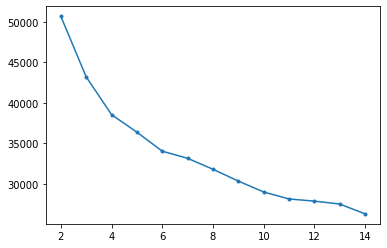

K value for max silhouette: 6


In [165]:
sse_list = []
for train, test in skf.split(feat_mush, lab_mush):
  max_silhouette = -1
  max_silhouette_index = 0
  for k in range(2, 15):
    mmodel = KMeans(n_clusters=k).fit(feat_mush[train])
    sse_list.append(mmodel.inertia_)
    s_score = silhouette_score(feat_mush[train], mmodel.labels_, metric='euclidean')
    if s_score > max_silhouette:
      max_silhouette = s_score
      max_silhouette_index = k
  plt.plot(list(range(2, 15)), sse_list, '.-')
  plt.show()
  print('K value for max silhouette:', max_silhouette_index)
  break
  

In [144]:
#RISK DATASET
skf1 = StratifiedKFold(n_splits=10)
print(skf1)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [0]:
rsse_list = []
for train, test in skf1.split(feat_risk, lab_risk):
  for k in range(1, 15):
    mmodel = KMeans(n_clusters=k).fit(feat_risk[train])
    rsse_list.append(mmodel.inertia_)
  break
  #print(feat_risk.loc[x_ind])
  #print(lab_risk.loc[y_ind])

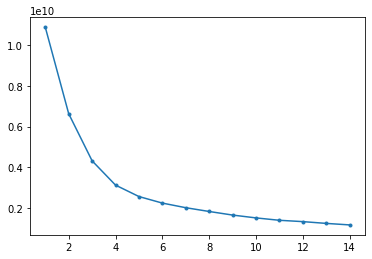

In [148]:
plt.plot(list(range(1, 15)), rsse_list, '.-')
plt.show()

In [0]:
#FRAUD DATASET
skf2 = StratifiedKFold(n_splits=10)
skf2.get_n_splits(feat_fraud, lab_fraud)
print(skf2)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [0]:
for x_ind, y_ind in skf2.split(feat_fraud, lab_fraud):
  #print(feat_fraud.loc[x_ind])
  #print(lab_fraud.loc[y_ind])
  pass